## Attach google drive and install all necessary requirements

In [1]:
!pip install scikit-learn pandas numpy matplotlib seaborn imblearn scipy

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import all the necessary libraries and datasets

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import scipy
import random
import os

In [9]:
data_train = pd.read_csv('/content/drive/MyDrive/sleep onset datasets/data_perfectly_clean_train.csv')
data_test = pd.read_csv('/content/drive/MyDrive/sleep onset datasets/data_perfectly_clean_test.csv')


In [10]:
selected_participants_data = pd.read_csv('/content/drive/MyDrive/sleep onset datasets/data_test_perfectly_clean_top_20.csv')
selected_participants = selected_participants_data['Sbj_ID'].unique().tolist()
selected_participants

[323,
 694,
 912,
 1476,
 2040,
 2651,
 2780,
 3920,
 4014,
 4190,
 4437,
 5749,
 5782,
 5838,
 5876,
 6454,
 10,
 2574,
 5489,
 5881]

## Define all the helper functions


In [ ]:
# Define the device:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#Create a PyTorch dataset
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
class SleepDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return torch.from_numpy(self.sequences[idx]).float(), torch.from_numpy(np.array(self.labels[idx])).float()

In [ ]:
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor

# Create a function to impute the missing values in the dataset
def impute_missing_values (dataframe, method = 'LOCF', limit = 20):

    # create a missing mask (column) fthat would indicate whether the values in any of the columns of mydata are missing
    # 1 indicates missing, 0 indicates not missing
    missing_mask = dataframe.isnull().sum(axis=1).astype(bool).astype(int)
    dataframe_imputed = dataframe.copy()
    dataframe_imputed = pd.concat([dataframe_imputed, missing_mask.rename('ifmissing')], axis=1)

    if method == 'LOCF':

        dataframe_imputed.fillna(method='ffill', inplace=True, limit = limit)

        # fill the rest with backward fill
        dataframe_imputed.fillna(method='bfill', inplace=True, limit = limit)

    elif method =='NOCB':

        dataframe_imputed.fillna(method='bfill', inplace=True, limit = limit)

        # fill the rest with forward fill
        #dataframe_imputed.fillna(method='ffill', inplace=True, limit = limit)

    elif method == 'linear interpolation':

        dataframe_imputed.interpolate(method='linear', inplace=True, limit = limit)

    elif method == 'quadratic interpolation':

        dataframe_imputed.interpolate(method='quadratic', inplace=True, limit = limit)

    elif method == 'mean':

        dataframe_imputed.fillna(dataframe.mean(), inplace=True, limit = limit)

    elif method == 'median':

        dataframe_imputed.fillna(dataframe.median(), inplace=True, limit = limit)

    elif method == 'MICE':

        # Define an imputer
        imp = IterativeImputer(estimator=RandomForestRegressor(n_estimators=10, random_state=0),
                            missing_values=np.nan,
                            sample_posterior=False,
                            max_iter=10,
                            random_state=0,
                            verbose=2)


        columns = dataframe_imputed.columns

        # Apply the imputer
        df_imputed = imp.fit_transform(dataframe_imputed)

        # Convert back to DataFrame
        dataframe_imputed = pd.DataFrame(df_imputed, columns=columns)

    elif method == 'None':
        dataframe_imputed = dataframe_imputed

    missing_mask_new = dataframe_imputed.isnull().sum(axis=1).astype(bool).astype(int)

    dataframe_imputed = pd.concat([dataframe_imputed, missing_mask_new.rename('ifmissing_after_imputation')], axis=1)

    return dataframe_imputed


In [ ]:


# Create a function for creating sliding windows of selected length

def create_sliding_windows(data,  window_size_minutes=5,
                           ifmissing = True, random_seed = 42, ifoutputsubjects = 0,
                           train_proportion = 0.6, ifoutput_end_points = 0,
                           resampling_method = None, resampling_proportion = 0.5, iftest = 1):

    # Assert whether therea are any NaNs in the data
    if not ifmissing:
        assert data.isnull().sum().sum() == 0, "There are NaNs in the data"

    # plot the distribution of labels in the original data
    #plt.hist(data['Label'], bins = 60)
    #plt.title('Distribution of labels in the original data')
    #plt.show()

    # check if there are any missing values in the data
    #print('Num NaNs in the data:',data.isnull().sum().sum())

    # Create a list of all unique subjects
    subjects = data['Sbj_ID'].unique()

    # Randomly select some of the 80% of subjects to be in the training set, 20% to the validation set and 20% in the test set
    np.random.seed(random_seed)


    train_subjects = np.random.choice(subjects, size=int(train_proportion*len(subjects)), replace=False)


    if iftest == 1:
        val_proportions = (1 - train_proportion)/2
        val_subjects = np.random.choice(np.setdiff1d(subjects, train_subjects), size=int(val_proportions*len(subjects)), replace=False)
        test_subjects = np.setdiff1d(subjects, np.concatenate((train_subjects, val_subjects)))
    else:
        val_proportions = 1 - train_proportion
        val_subjects = np.setdiff1d(subjects, train_subjects)
        test_subjects = []



    # Print the number of subjects in each set
    #print(f'There are {len(train_subjects)} subjects in the training set, {len(val_subjects)} subjects in the validation set and {len(test_subjects)} subjects in the test set')


    # Create a new column in the dataframe that indicates whether the subject is in the training set, val set or the test set
    data['Set'] = 'train'
    data.loc[data['Sbj_ID'].isin(val_subjects), 'Set'] = 'val'
    data.loc[data['Sbj_ID'].isin(test_subjects), 'Set'] = 'test'

    # Sort your dataframe by Sbj_ID if not already sorted
    data = data.sort_values('Sbj_ID')

    # Convert the window size from minutes to 6-second epochs
    window_size = int((window_size_minutes*60)/6)

    # Create empty lists to store your sequences and labels
    train_sequences = []
    train_labels = []
    val_sequences = []
    val_labels = []
    test_sequences = []
    test_labels = []

    # Group the DataFrame by subject ID and iterate over each group, dividing into training and test sets
    if ifoutput_end_points == 1:
        test_end_points = []
        test_sleep_stages = []
        test_labels = []
        val_sleep_stages = []
        val_end_points = []
    for _, group in data.groupby('Sbj_ID'):

        # sort the group by the label in descending order
        group = group.sort_values('Label', ascending=False)



        # For each group, get the feature columns and convert them into numpy array
        if ifoutput_end_points == 1:
             group_features = group.drop(['Sbj_ID', 'Label', 'Set', 'ifmissing_after_imputation', 'Old_label', 'ifCleanOnset', 'Time2Sleep', 'SleepStage'], axis=1).to_numpy()
             group_old_labels = group['Old_label'].to_numpy()
             group_sleep_stages = group['SleepStage'].to_numpy()
             group_labels = group['Label'].to_numpy()
        else:
            group_features = group.drop(['Sbj_ID', 'Label', 'Set', 'ifmissing_after_imputation', 'ifCleanOnset', 'Time2Sleep', 'SleepStage'], axis=1).to_numpy()

        ifmissing_column = group['ifmissing_after_imputation'].to_numpy()

        train_test = group['Set'].iloc[0]

        #if window_size == len(group_features):
         #   if train_test == 'train':
        #        train_sequences.append(group_features)
         #       train_labels.append(group['Label'].iloc[0])
         #   elif train_test == 'val':
         #       val_sequences.append(group_features)
         #       val_labels.append(group['Label'].iloc[0])
          #  elif train_test == 'test':
         #       test_sequences.append(group_features)
          #      test_labels.append(group['Label'].iloc[0])
       # elif window_size > len(group_features):
        #    continue

        # Iterate over the group array with a sliding window
        for i in range(len(group_features) - window_size):

            # If there are any NaNs in the window, skip it
            if ifmissing_column[i : i + window_size].sum() > 0:
                continue

            if train_test == 'train':

                # Append the window data to your sequences
                train_sequences.append(group_features[i : i + window_size])

                # Append the label corresponding to the end of the window
                train_labels.append(group['Label'].iloc[i+window_size])

                if ifoutput_end_points == 1:
                    # Append the starting point of the window to the list of starting points
                    test_end_points.append(group_old_labels[i+window_size])
                    test_sleep_stages.append(group_sleep_stages[i+window_size])

            elif train_test == 'val':
                # Append the window data to your sequences
                val_sequences.append(group_features[i : i + window_size])

                # Append the label corresponding to the end of the window
                val_labels.append(group['Label'].iloc[i+window_size])

                if ifoutput_end_points == 1:
                    # Append the starting point of the window to the list of starting points
                    val_end_points.append(group_old_labels[i+window_size])
                    val_sleep_stages.append(group_sleep_stages[i+window_size])


            elif train_test == 'test':

                # Append the window data to your sequences
                test_sequences.append(group_features[i : i + window_size])

                # Append the label corresponding to the end of the window
                test_labels.append(group['Label'].iloc[i+window_size])


    # Convert the sequences and labels into numpy arrays
    train_sequences = np.array(train_sequences)
    train_labels = np.array(train_labels)



    val_sequences = np.array(val_sequences)
    val_labels = np.array(val_labels)
    test_sequences = np.array(test_sequences)
    test_labels = np.array(test_labels)

    # plot the distribution of labels in the training set
    #plt.hist(train_labels, bins = 60)
    #plt.title('Distribution of labels in the training set')
    #plt.show()

    #if val_labels.size > 0:
    #    # plot the distribution of labels in the validation set
    #    plt.hist(val_labels, bins = 60)
    #    plt.title('Distribution of labels in the validation set')
    #    plt.show()

    #if test_labels.size > 0:
    #    # plot the distribution of labels in the test set
    #    plt.hist(test_labels, bins = 60)
    #    plt.title('Distribution of labels in the test set')
    #    plt.show()


    if iftest == 1:
        if ifoutputsubjects:
            if ifoutput_end_points == 1:
                return train_sequences, train_labels, val_sequences, val_labels, test_sequences, test_labels, train_subjects, val_subjects, test_subjects, test_end_points, test_sleep_stages
            else:
                return train_sequences, train_labels, val_sequences, val_labels, test_sequences, test_labels, train_subjects, val_subjects, test_subjects
        else:
            if ifoutput_end_points == 1:
                return train_sequences, train_labels, val_sequences, val_labels, test_sequences, test_labels, test_end_points, test_sleep_stages
            else:
                return train_sequences, train_labels, val_sequences, val_labels,  test_sequences, test_labels
    else:
        if ifoutputsubjects:
            if ifoutput_end_points == 1:
                return train_sequences, train_labels, val_sequences, val_labels,  train_subjects, val_subjects, val_end_points, val_sleep_stages
            else:
                return train_sequences, train_labels, val_sequences, val_labels, train_subjects, val_subjects

        else:
            if ifoutput_end_points == 1:
                return train_sequences, train_labels, val_sequences, val_labels, val_end_points, val_sleep_stages
            else:
                return train_sequences, train_labels, val_sequences, val_labels


In [ ]:
import torch
from sklearn.metrics import mean_squared_error, r2_score

def train_regression(model, train_loader, num_epochs, criterion,
                     optimizer, device, ifplot=False, ifvalidation = True, val_loader = None):

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))

        # Train the model
        model.train()
        running_train_loss = 0.0
        train_predictions, train_actuals = [], []
        for i, (inputs, labels) in enumerate(train_loader):
            inputs = inputs.to(device)
            labels= labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels.view(-1, 1))

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item()
            outputs_detached = outputs.detach()
            train_predictions.extend(outputs_detached.cpu().numpy().flatten())
            train_actuals.extend(labels.cpu().numpy())

        avg_train_loss = running_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)



        if ifvalidation:
            # Validate the model
            model.eval()
            running_val_loss = 0.0
            val_predictions, val_actuals = [], []
            with torch.no_grad():
                for inputs, labels in val_loader:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    outputs = model(inputs)
                    running_val_loss += criterion(outputs, labels.view(-1, 1)).item()
                    val_predictions.extend(outputs.cpu().numpy().flatten())
                    val_actuals.extend(labels.cpu().numpy())



                avg_val_loss = running_val_loss / len(val_loader)
                val_losses.append(avg_val_loss)

        # Calculate metrics
        if ifvalidation:
            mse = mean_squared_error(val_actuals, val_predictions)
            r2 = r2_score(val_actuals, val_predictions)
            mae = mean_absolute_error(val_actuals, val_predictions)
        else:
            mse = mean_squared_error(train_actuals, train_predictions)
            r2 = r2_score(train_actuals, train_predictions)
            mae = mean_absolute_error(train_actuals, train_predictions)

        if ifplot:
            print('-'*100)
            if ifvalidation:
                print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}')
            else:
                print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss}')
            print(f'Mean Squared Error: {mse}, R2 Score: {r2}')
            print(f'Mean Absolute Error: {mae}')
    if ifvalidation:
        del train_predictions, train_actuals
        return  val_predictions, val_actuals, train_losses, val_losses, model, optimizer
    else:
        return  train_predictions, train_actuals, train_losses, model, optimizer


# Test function
def test_regression(model, test_loader, device, criterion, ifplot=False):
    model.eval()
    predictions, actuals = [], []

    with torch.no_grad():
        test_loss = 0
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)  # these are outputs now
            test_loss += criterion(outputs, labels.view(-1, 1)).item()

            predictions.extend(outputs.cpu().numpy().flatten())
            actuals.extend(labels.cpu().numpy())
        if ifplot:
            print(f'Test Loss: {test_loss/len(test_loader)}')

    # Calculate metrics
    mse = mean_squared_error(actuals, predictions)
    r2 = r2_score(actuals, predictions)
    mae = mean_absolute_error(actuals, predictions)
    if ifplot:
        print('Mean Squared Error:', mse)
        print('R2 Score:', r2)
        print('Mean Absolute Error:', mae)
    del mse, r2, mae
    return predictions, actuals

In [ ]:
def evaluate_regression(predictions, y_test, ifsaveplots = False, savepath = None, ifplot = False, iftest = False, ifperson = False):

    # check if the predictions are in the correct format

    predictions = np.array(predictions)

    # check if the y_test is in the correct format

    y_test = np.array(y_test)

    errors = abs(y_test - predictions)
    mape = np.where(y_test != 0, 100 * (errors / y_test), 0)
    accuracy = 100 - np.mean(mape)
    mse = sklearn.metrics.mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    r2 = sklearn.metrics.r2_score(y_test, predictions)
    squared_errors = np.square(y_test - predictions)
    weights = 1.0 / (abs(y_test) + 0.1)
    custom_mse = np.mean(weights * squared_errors)

    if ifplot:

        print('Mean Absolute Error:', round(np.mean(errors), 2))
        print('Accuracy:', round(accuracy, 2), '%.')
        print('Mean Squared Error:', round(mse, 2))
        print('Root Mean Squared Error:', round(rmse, 2))
        print('R2:', round(r2, 2))
        print('Custom MSE:', round(custom_mse, 2))

    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=1)
    plt.scatter(y_test, predictions, alpha=0.2)
    plt.xlabel('Actual time to sleep onset')
    plt.ylabel('Predicted time to sleep onset')
    plt.title('Actual vs Predicted time to sleep onset')
    if ifsaveplots:
        if iftest:
            plt.savefig(os.path.join(savepath, 'test_actual_vs_predicted.png'))
        else:
            plt.savefig(os.path.join(savepath, 'crossval_actual_vs_predicted.png'))
    if ifplot:
        plt.show()
    plt.close()

    residuals = y_test - predictions
    plt.scatter(y_test, residuals, alpha=0.2)
    plt.plot([y_test.min(), y_test.max()], [0, 0], 'k--', lw=1)
    plt.xlabel('Actual time to sleep onset')
    plt.ylabel('Residuals')
    plt.title('Actual vs Residuals for predicted time to sleep onset')
    if ifsaveplots:
        if iftest:
            plt.savefig(os.path.join(savepath, 'test_actual_vs_residuals.png'))
        else:
            plt.savefig(os.path.join(savepath, 'crossval_actual_vs_residuals.png'))
    if ifplot:
        plt.show()
    plt.close()

    plt.hist(residuals)
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.title('Residuals distribution')
    if ifsaveplots:
        if iftest:
            plt.savefig(os.path.join(savepath, 'test_residuals_distribution.png'))
        else:
            plt.savefig(os.path.join(savepath, 'crossval_residuals_distribution.png'))
    if ifplot:
        plt.show()
    plt.close()

    # for each actual, plot the mean residual
    # round y_test to 0.1 decimal place
    y_test = np.round(y_test, 1)

    predictions_residuals_dict = {}
    for i in range(len(y_test)):
        if y_test[i] not in predictions_residuals_dict:
            predictions_residuals_dict[y_test[i]] = []
        predictions_residuals_dict[y_test[i]].append(residuals[i])

    # sort it in ascending order of keys
    predictions_residuals_dict = dict(sorted(predictions_residuals_dict.items()))


    actual_predictions_dict = {}
    for i in range(len(y_test)):
        if y_test[i] not in actual_predictions_dict:
            actual_predictions_dict[y_test[i]] = []
        actual_predictions_dict[y_test[i]].append(predictions[i])

    # sort it in ascending order of keys
    actual_predictions_dict = dict(sorted(actual_predictions_dict.items()))


    predictions_residuals_mean_dict = {}
    for key in predictions_residuals_dict:
        predictions_residuals_mean_dict[key] = np.mean(predictions_residuals_dict[key])

    # sort it in ascending order of keys
    predictions_residuals_mean_dict = dict(sorted(predictions_residuals_mean_dict.items()))


    residuals_std_dict = {}
    for key in predictions_residuals_dict:
        residuals_std_dict[key] = np.std(predictions_residuals_dict[key])
    # sort it in ascending order of keys
    residuals_std_dict = dict(sorted(residuals_std_dict.items()))


    actuals_predictions_mean_dict = {}
    for key in actual_predictions_dict:
        actuals_predictions_mean_dict[key] = np.mean(actual_predictions_dict[key])

    # sort it in ascending order of keys
    actuals_predictions_mean_dict = dict(sorted(actuals_predictions_mean_dict.items()))

    predictions_std_dict = {}
    for key in actual_predictions_dict:
        predictions_std_dict[key] = np.std(actual_predictions_dict[key])
    # sort it in ascending order of keys
    predictions_std_dict = dict(sorted(predictions_std_dict.items()))

    plt.plot(list(predictions_residuals_mean_dict.keys()), list(predictions_residuals_mean_dict.values()))
    # create std shading
    if not ifperson:
        plt.fill_between(list(predictions_residuals_mean_dict.keys()),
                        np.array(list(predictions_residuals_mean_dict.values())) - np.array(list(residuals_std_dict.values())),
                        np.array(list(predictions_residuals_mean_dict.values())) + np.array(list(residuals_std_dict.values())),
                        alpha=0.2)
    # plot ideal line (x = 0)


    plt.plot([y_test.min(), y_test.max()], [0, 0], 'k--', lw=1, color='red')

    plt.xlabel('Actual time to sleep onset')
    plt.ylabel('Residuals for this actual')
    if ifperson:
        plt.legend(['Residuals', 'Ideal residuals line'])
        plt.title('Residuals for each actual time to sleep onset')
    else:
      plt.legend(['Mean of residuals', 'STD of residuals', 'Ideal residuals line'])
      plt.title('Mean residual of predictions for each actual time to sleep onset')


    if ifsaveplots:
        if iftest:
            plt.savefig(os.path.join(savepath, 'test_mean_residuals_across_time.png'))
        else:
            plt.savefig(os.path.join(savepath, 'crossval_mean_residuals_across_time.png'))
    if ifplot:
        plt.show()
    plt.close()

    plt.plot(list(actuals_predictions_mean_dict.keys()), list(actuals_predictions_mean_dict.values()))
    # create std shading
    if not ifperson:
        plt.fill_between(list(actuals_predictions_mean_dict.keys()),
                          np.array(list(actuals_predictions_mean_dict.values())) - np.array(list(predictions_std_dict.values())),
                          np.array(list(actuals_predictions_mean_dict.values())) + np.array(list(predictions_std_dict.values())),
                          alpha=0.2)
    # plot ideal line (x = y)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=1, color='red')

    plt.xlabel('Actual time to sleep onset')
    plt.ylabel('Mean prediction for this actual')

    if ifperson:
        plt.legend(['Predicted time to sleep','Ideal actual = prediction line (x = y)'])
        plt.title('Predicted time for each actual time to sleep onset')
    else:
        plt.legend(['Mean of predicted time to sleep onset', 'STD of predictions', 'Ideal actual = prediction line (x = y)'])
        plt.title('Mean predicted time for each actual time to sleep onset')

    if ifsaveplots:
        if iftest:
            plt.savefig(os.path.join(savepath, 'test_mean_predictions_across_time.png'))
        else:
             plt.savefig(os.path.join(savepath, 'crossval_mean_predictions_across_time.png'))
    if ifplot:
        plt.show()
    plt.close()

    test_metrics = {'MAE': round(np.mean(errors), 2), 'Accuracy': round(accuracy, 2),
    'MSE': round(mse, 2), 'RMSE': round(rmse, 2), 'R2': round(r2, 2), 'custom_MSE': round(custom_mse, 2)}


    del predictions, predictions_residuals_dict
    del actual_predictions_dict, predictions_residuals_mean_dict
    del actuals_predictions_mean_dict, predictions_std_dict, residuals, residuals_std_dict, y_test
    del mse, rmse, r2, custom_mse

    return test_metrics

In [ ]:
def create_participant_dataloader(data, method, filling_limit, window_size_minutes, random_seed=42):
    participant_dataloaders = {}

    for sbj in data['Sbj_ID'].unique():

        participant_data = data[data['Sbj_ID'] == sbj].copy()

        participant_data_imputed = impute_missing_values(participant_data, method=method, limit=filling_limit)
        ifmissing = participant_data_imputed.isnull().sum().sum()

        test_sequences_sbj, test_targets_sbj, _, _ = create_sliding_windows(
            participant_data_imputed,
            window_size_minutes=window_size_minutes,
            ifmissing=ifmissing,
            random_seed=random_seed,
            ifoutputsubjects=0,
            train_proportion=1,
            ifoutput_end_points=0,
            resampling_method=None,
            resampling_proportion=0.5,
            iftest=0
        )

        # Check if test_sequences_sbj and test_targets_sbj are empty
        if len(test_sequences_sbj) == 0 or len(test_targets_sbj) == 0:
            print(f"Skipping participant {sbj} due to lack of data.")
            continue

        # Create the test dataset and dataloader with labels and end points (for the regression head)
        test_dataset_sbj = SleepDataset(test_sequences_sbj, test_targets_sbj)
        test_loader_sbj = DataLoader(test_dataset_sbj, batch_size=1, shuffle=False)

        participant_dataloaders[sbj] = test_loader_sbj

    return participant_dataloaders


In [ ]:
def test_reg_on_random_participants(participant_dataloaders, model, criterion, device, random_seed, ifplot, output_path_new):

    """
    Test the model on a random subset of participants.
    """
    # Set random seed

    # create a new folder for the results
    output_path_new = os.path.join(output_path_new, 'random_participants')
    if not os.path.exists(output_path_new):
        os.makedirs(output_path_new)

    # intialise empty dataframe to store results
    df_all = pd.DataFrame()


    for sbj in list(participant_dataloaders.keys()):
        # create a folder for each participant

        output_path_participant = os.path.join(output_path_new, str(sbj))
        if not os.path.exists(output_path_participant):
            os.makedirs(output_path_participant)

        test_dataloader = participant_dataloaders[sbj]

        predictions, actuals = test_regression(model, test_dataloader, device, criterion)

        # get the accuracy of each timepoint
        if ifplot:
            print('Predict for participant: ', sbj)

            print('--------------------------------------Evaluate regression ----------------------------------------')

        test_metrics = evaluate_regression(predictions, actuals, iftest=True,
                                ifplot=ifplot, savepath =output_path_participant, ifsaveplots= True, ifperson = True)


        del test_dataloader, predictions, actuals
        df = pd.DataFrame(test_metrics, index = [sbj])
        df_all = pd.concat([df_all, df])
        del test_metrics

    df_all.to_csv(os.path.join(output_path_new, 'regression_results_random_participants.csv'))



In [ ]:
import torch
import torch.nn as nn

class SleepOnsetRNNRegressor(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers, output_size=1, dropout=0.0, l2=0.0):
        super(SleepOnsetRNNRegressor, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.l2 = l2

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
       #prob = self.sigmoid(out)
        return out


In [ ]:
def plot_losses(train_losses, test_losses, title, ifplot, ifsaveplots, save_directory, filename, iftest = False):

    plt.plot(train_losses, label='Training loss')
    if iftest:
        plt.plot(test_losses, label='Test loss')
    else:
      plt.plot(test_losses, label='Validation loss')
    plt.title(title)
    plt.legend()
    if ifplot:
        plt.show()
    if ifsaveplots:
        plt.savefig(os.path.join(save_directory, filename))
    plt.close()

In [ ]:
def train_and_evaluate_regression_model(model, train_loader, test_loader, criterion, optimizer, device, num_epochs, ifplot, ifsaveplots, output_path):
    test_predictions, test_actuals, train_losses, test_losses, model, optimizer = train_regression(
        model = model, train_loader = train_loader, val_loader = test_loader, num_epochs = num_epochs, criterion = criterion, optimizer =optimizer, device = device, ifplot = ifplot, ifvalidation = True)

    test_metrics = evaluate_regression(test_predictions, test_actuals, ifsaveplots=ifsaveplots, savepath=output_path, ifplot = ifplot)

    return train_losses, test_losses, model, optimizer, test_predictions, test_actuals, test_metrics

In [ ]:
def save_model(model, save_directory, hidden_size, batch_size, window_size_minutes, method):
    model_path = os.path.join(save_directory, f'model_h{hidden_size}_b{batch_size}_w{window_size_minutes}_{method}.pt')
    torch.save(model.state_dict(), model_path)


In [ ]:
from sklearn.metrics import mean_squared_error
import warnings

def training_loop_feature_RNN_regression(mydata, filling_limit, method, input_size, num_epochs, l2, lr, weight_decay, batch_size, device, hidden_size, num_layers,
                                        random_seed=42, window_size_minutes=1,  iftest=False, ifoutputpredictions=0,
                                        if_stratified_sampling=1, resampling_method=None, ifplot=False, ifresetresults = False,
                                        ifsaveplots=True, output_path=None, results_saving_dir = None, loss_function = None, iftrainshuffle = False,
                                        selected_participants_data = None, selected_participants = None, test_data =None, pretrained_model = None):

    ################## INITIALISATION OF RESULTS STORAGE ##################
    warnings.filterwarnings('ignore', category=RuntimeWarning)
    warnings.filterwarnings('ignore', category=UserWarning)

    if results_saving_dir is None:
        results_saving_dir = output_path

    save_directory = output_path

    if not os.path.exists(save_directory):
        os.makedirs(save_directory)

    # Initialize a DataFrame to store results
    columns = ['hidden_size', 'batch_size', 'sliding_window_size', 'imputation_method',
                'MAE', 'MSE', 'RMSE', 'Accuracy', 'R2', 'custom_MSE']

    if ifresetresults:
        results_df = pd.DataFrame(columns=columns)
        results_df.to_csv(os.path.join(results_saving_dir, 'results.csv'))

    model_parameters = {'hidden_size': hidden_size,
                            'batch_size': batch_size,
                            'sliding_window_size': window_size_minutes,
                            'imputation_method': method}

    ################## PREPROCESS THE DATA: IMPUTATION AND WINDOW CREATION ##################
    mydata_imputed = impute_missing_values(mydata, method=method, limit=filling_limit)

    if test_data is not None:
        test_data_unimputed = test_data.copy()
        test_data = impute_missing_values(test_data, method=method, limit=filling_limit)
        ifmissing_test = test_data.isnull().sum().sum()

    # Check if the dataset still has any missing values
    ifmissing = mydata_imputed.isnull().sum().sum()

    # Depending on the 'ifprobabilitiesanalysis' flag, process the data differently
   # if iftest:
    #    train_sequences, train_targets, val_sequences, val_targets, test_sequences, test_targets = create_sliding_windows(mydata_imputed,  window_size_minutes=window_size_minutes,
       #                                                                                                             ifmissing = ifmissing, random_seed = 42, ifoutputsubjects = 0,
       #                                                                                                             train_proportion = 0.9, ifoutput_end_points = 0,
        #                                                                                                            resampling_method = None, resampling_proportion = 0.5, iftest = iftest)
   # else:
    if iftest and test_data is not None:
        if pretrained_model is None:
            train_sequences, train_targets, _, _ = create_sliding_windows(mydata_imputed,  window_size_minutes=window_size_minutes,
                                                                                                                ifmissing = ifmissing, random_seed = 42, ifoutputsubjects = 0,
                                                                                                                    train_proportion = 1.0, ifoutput_end_points = 0,
                                                                                                                    resampling_method = None, resampling_proportion = 0.5, iftest = False)
        test_sequences, test_targets, _, _ = create_sliding_windows(test_data,  window_size_minutes=window_size_minutes,
                                                                 ifmissing = ifmissing_test, random_seed = 42, ifoutputsubjects = 0,
                                                                 train_proportion = 1.0, ifoutput_end_points = 0,
                                                                 resampling_method = None, resampling_proportion = 0.5, iftest = False)
    else:
        train_sequences, train_targets, val_sequences, val_targets = create_sliding_windows(mydata_imputed,  window_size_minutes=window_size_minutes,
                                                                                                                ifmissing = ifmissing, random_seed = 42, ifoutputsubjects = 0,
                                                                                                                    train_proportion = 0.9, ifoutput_end_points = 0,
                                                                                                                    resampling_method = None, resampling_proportion = 0.5, iftest = False)

    ################### PREPARE LOSS FUNCTION, DATASETS, OPTIMIZER AND MODEL FOR DEEP LEARNING ##################
    if loss_function is None:
        criterion = nn.MSELoss()
    else:
        criterion = loss_function

    # Create the training, validation, and test datasets
    if pretrained_model is None:
        train_dataset = SleepDataset(train_sequences, train_targets)
         # Create the data loaders
        if iftrainshuffle:
            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle =True)
        else:
            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle =False)
    if iftest and test_data is not None:
        test_dataset = SleepDataset(test_sequences, test_targets)
    else:
        val_dataset = SleepDataset(val_sequences, val_targets)




    if iftest and test_data is not None:
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
        participant_dataloaders = create_participant_dataloader(test_data_unimputed, method, filling_limit, window_size_minutes, random_seed = random_seed)
    else:
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    if selected_participants_data is not None:
        participant_dataloaders = create_participant_dataloader(selected_participants_data, method, filling_limit, window_size_minutes, random_seed = random_seed)

    # Initialize the model (This model needs to be defined as a regression model)
    if pretrained_model is None:
        model = SleepOnsetRNNRegressor(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers).to(device)

        # Define the optimizer
        optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    ################################# TRAIN THE MODEL  ########################################

    if iftest and test_data is not None:
        if pretrained_model is None:
          train_losses_reg, test_losses_reg, model, optimizer, val_predictions, val_actuals, test_metrics = train_and_evaluate_regression_model(model = model, train_loader =train_loader,
                                                                                                                                        test_loader = test_loader, criterion = criterion,
                                                                                                                                        optimizer = optimizer, device = device, num_epochs = num_epochs, ifplot = ifplot,
                                                                                                                                        ifsaveplots = ifsaveplots, output_path = save_directory)
        else:
            predictions, actuals = test_regression(model = pretrained_model, test_loader = test_loader, device = device, criterion = criterion, ifplot=False)
            test_metrics = evaluate_regression(predictions, actuals, ifsaveplots = ifsaveplots, savepath = save_directory, ifplot = ifplot, iftest = True)
    else:
        train_losses_reg, test_losses_reg, model, optimizer, val_predictions, val_actuals, test_metrics = train_and_evaluate_regression_model(model = model, train_loader =train_loader,
                                                                                                                                        test_loader = val_loader, criterion = criterion,
                                                                                                                                    optimizer = optimizer, device = device, num_epochs = num_epochs, ifplot = ifplot,
                                                                                                                                        ifsaveplots = ifsaveplots, output_path = save_directory)
    if selected_participants is not None:

        test_reg_on_random_participants(participant_dataloaders = participant_dataloaders, model = model,  criterion = criterion,
                                                device = device, random_seed = random_seed, ifplot = ifplot, output_path_new =save_directory)
    if iftest and test_data is not None:
        if pretrained_model is None:
            test_reg_on_random_participants(participant_dataloaders = participant_dataloaders, model = model,  criterion = criterion,
                                                device = device, random_seed = random_seed, ifplot = ifplot, output_path_new =save_directory)
        else:
            test_reg_on_random_participants(participant_dataloaders = participant_dataloaders, model = pretrained_model,  criterion = criterion,
                                                device = device, random_seed = random_seed, ifplot = ifplot, output_path_new =save_directory)



    # After each epoch, save the model
    if pretrained_model is None:
        save_model(model, save_directory, hidden_size, batch_size, window_size_minutes, method)

    if pretrained_model is None:
      # plot the losses for the regression model
      filename = 'regression_losses.png'
      if iftest and test_data is not None:
        title = 'Training and test losses during regression with window size of ' + str(window_size_minutes) + ' minutes'
      else:
        title = 'Training and validation losses during regression with window size of ' + str(window_size_minutes) + ' minutes'
      plot_losses(train_losses_reg, test_losses_reg, title,
                  ifplot, ifsaveplots,
                  save_directory = save_directory, filename = filename)


    # joing two dictionaries
    all_metrics = {**model_parameters, **test_metrics}
    # populate the results_df dataframe with the results from the current epoch
    new_row = pd.DataFrame(all_metrics, index = [0])
    print(new_row)

    # Open the results dataframe and add the new results
    results_df_all = pd.read_csv(os.path.join(results_saving_dir, 'results.csv'))
    results_df_all = pd.concat([results_df_all, new_row], ignore_index=True)
    print(results_df_all)

    results_df_all.to_csv(os.path.join(results_saving_dir, 'results.csv'), index=False)

    del results_df_all
    del new_row
    del all_metrics

    # Clean up the cuda memory
    torch.cuda.empty_cache()
    # close all the plots
    plt.close('all')
    # clean up the memory
    gc.collect()

    #if ifoutputpredictions:
    #    return train_losses, val_losses, model, predictions, actuals, mse
    # else:
    #    return train_losses, val_losses, model




In [ ]:
import torch
import torch.nn as nn

class CustomMSELoss(nn.Module):
    def __init__(self, epsilon=0.1):
        super(CustomMSELoss, self).__init__()
        self.epsilon = epsilon  # Small value to prevent division by zero

    def forward(self, predictions, targets):
        # Compute error
        errors = (predictions - targets)**2

        # Compute weights inversely proportional to target values
        weights = 1.0 / (torch.abs(targets) + self.epsilon)

        # Weighted sum of errors
        loss = torch.sum(weights * errors) / torch.sum(weights)
        return loss

# Test the custom loss
predictions = torch.tensor([0.5, 0.2, 0.7])
targets = torch.tensor([0.1, 0.4, 0.8])
criterion = CustomMSELoss()
loss = criterion(predictions, targets)
print(loss)


tensor(0.1099)


In [ ]:
import os
import gc
def hyperparameter_tuning_loop(mydata, hidden_sizes, batch_sizes, window_sizes, imputation_methods,
                            results_saving_dir = 'regression_LSTM',  ifresetresults = False,
                            selected_participants_data = None, selected_participants = None,
                            test_data = None, if_pretrained_model = False, extraction_name = None):

    if not os.path.exists(results_saving_dir):
        os.makedirs(results_saving_dir)

    # Initialize a DataFrame to store results
    columns = ['hidden_size', 'batch_size', 'sliding_window_size', 'imputation_method',
                'MAE', 'MSE', 'RMSE', 'R2', 'Accuracy', 'custom_MSE']



    if ifresetresults:
        results_df_all = pd.DataFrame(columns=columns)
        results_df_all.to_csv(os.path.join(results_saving_dir, 'results.csv'))



    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    for hidden_size in hidden_sizes:
        for batch_size in batch_sizes:
            for window_size_minutes in window_sizes:
                for imputation_method in imputation_methods:
                    if imputation_method == 'None':
                        method = None
                        filling_limit = 0
                    else:
                        method = imputation_method
                        filling_limit = 40


                    gc.collect()
                    torch.cuda.empty_cache()

                    experiment_dir = os.path.join(results_saving_dir, f'hidden_{hidden_size}_batch_{batch_size}_window_{window_size_minutes}_imputation_{imputation_method}')
                    if not os.path.exists(experiment_dir):
                        os.makedirs(experiment_dir)

                    print('Hidden size: ', hidden_size)
                    print('Batch_size: ', batch_size)
                    print('Window size: ', window_size_minutes)
                    print('Imputation method: ', method)

                    if test_data is not None:
                      iftest = True
                    else:
                      iftest = False

                    if if_pretrained_model:
                      pretrained_model = extract_models_from_folder(extraction_name,  hidden_size, batch_size, window_size_minutes, imputation_method)
                    else:
                      pretrained_model = None

                    training_loop_feature_RNN_regression(mydata, filling_limit = filling_limit, method = method, input_size = 86, num_epochs = 30,
                                            l2 = 0, lr = 0.001, weight_decay = 0.05, batch_size = batch_size, device = device,
                                            hidden_size = hidden_size, num_layers = 2,
                                            random_seed=42, window_size_minutes=window_size_minutes,
                                            iftest=iftest, ifoutputpredictions=0,
                                            if_stratified_sampling=1, resampling_method=None,
                                            ifplot=False, ifsaveplots=True, output_path=experiment_dir, results_saving_dir = results_saving_dir,
                                            loss_function = CustomMSELoss(), iftrainshuffle = True, ifresetresults = False,
                                            selected_participants_data = selected_participants_data, selected_participants = selected_participants,
                                            test_data = test_data, pretrained_model = pretrained_model)


## Hyperparameter tuning

In [ ]:
hidden_sizes = [64, 128, 256]
batch_sizes = [16, 32, 64]
window_sizes = [0.5, 1, 2, 3, 4, 5]
imputation_methods = ['None', 'LOCF']

In [ ]:
folder_name = '/content/drive/MyDrive/sleep onset datasets/FIXED_regression_LSTM_perfectly_clean_onset'

In [ ]:
hyperparameter_tuning_loop(data_train, hidden_sizes, batch_sizes, window_sizes, imputation_methods,
                            results_saving_dir = folder_name,  ifresetresults = True,
                            selected_participants_data = selected_participants_data, selected_participants = selected_participants)

Hidden size:  64
Batch_size:  16
Window size:  0.5
Imputation method:  None
Epoch 1/30
Epoch 2/30
Epoch 3/30
Epoch 4/30
Epoch 5/30
Epoch 6/30
Epoch 7/30
Epoch 8/30
Epoch 9/30
Epoch 10/30
Epoch 11/30
Epoch 12/30
Epoch 13/30
Epoch 14/30
Epoch 15/30
Epoch 16/30
Epoch 17/30
Epoch 18/30
Epoch 19/30
Epoch 20/30
Epoch 21/30
Epoch 22/30
Epoch 23/30
Epoch 24/30
Epoch 25/30
Epoch 26/30
Epoch 27/30
Epoch 28/30
Epoch 29/30
Epoch 30/30
   hidden_size  batch_size  sliding_window_size imputation_method   MAE  \
0           64          16                  0.5              None  7.09   

   Accuracy        MSE  RMSE    R2  custom_MSE  
0     10.35  86.709999  9.31 -0.13        8.01  
  Unnamed: 0 hidden_size batch_size  sliding_window_size imputation_method  \
0        NaN          64         16                  0.5              None   

    MAE        MSE  RMSE    R2  Accuracy  custom_MSE  
0  7.09  86.709999  9.31 -0.13     10.35        8.01  
Hidden size:  64
Batch_size:  16
Window size:  0.5
Imputa

In [ ]:
hidden_sizes = [64]
batch_sizes = [64]
window_sizes = [4, 5]
imputation_methods = ['None', 'LOCF']
hyperparameter_tuning_loop(data_train, hidden_sizes, batch_sizes, window_sizes, imputation_methods,
                            results_saving_dir = folder_name,  ifresetresults = False,
                            selected_participants_data = selected_participants_data, selected_participants = selected_participants)

Hidden size:  64
Batch_size:  64
Window size:  4
Imputation method:  None
Epoch 1/30
Epoch 2/30
Epoch 3/30
Epoch 4/30
Epoch 5/30
Epoch 6/30
Epoch 7/30
Epoch 8/30
Epoch 9/30
Epoch 10/30
Epoch 11/30
Epoch 12/30
Epoch 13/30
Epoch 14/30
Epoch 15/30
Epoch 16/30
Epoch 17/30
Epoch 18/30
Epoch 19/30
Epoch 20/30
Epoch 21/30
Epoch 22/30
Epoch 23/30
Epoch 24/30
Epoch 25/30
Epoch 26/30
Epoch 27/30
Epoch 28/30
Epoch 29/30
Epoch 30/30
   hidden_size  batch_size  sliding_window_size imputation_method   MAE  \
0           64          64                    4              None  5.51   

   Accuracy        MSE  RMSE    R2  custom_MSE  
0    -27.85  53.869999  7.34  0.16       12.62  
    Unnamed: 0  hidden_size  batch_size  sliding_window_size  \
0          NaN           64          16                  0.5   
1          NaN           64          16                  0.5   
2          NaN           64          16                  1.0   
3          NaN           64          16                  1.0   
4     

In [ ]:
hidden_sizes = [128]
batch_sizes = [16, 32, 64]
window_sizes = [0.5, 1, 2, 3, 4, 5]
imputation_methods = ['None', 'LOCF']
hyperparameter_tuning_loop(data_train, hidden_sizes, batch_sizes, window_sizes, imputation_methods,
                            results_saving_dir = folder_name,  ifresetresults = False,
                            selected_participants_data = selected_participants_data, selected_participants = selected_participants)

Hidden size:  128
Batch_size:  16
Window size:  0.5
Imputation method:  None
Epoch 1/30
Epoch 2/30
Epoch 3/30
Epoch 4/30
Epoch 5/30
Epoch 6/30
Epoch 7/30
Epoch 8/30
Epoch 9/30
Epoch 10/30
Epoch 11/30
Epoch 12/30
Epoch 13/30
Epoch 14/30
Epoch 15/30
Epoch 16/30
Epoch 17/30
Epoch 18/30
Epoch 19/30
Epoch 20/30
Epoch 21/30
Epoch 22/30
Epoch 23/30
Epoch 24/30
Epoch 25/30
Epoch 26/30
Epoch 27/30
Epoch 28/30
Epoch 29/30
Epoch 30/30
   hidden_size  batch_size  sliding_window_size imputation_method   MAE  \
0          128          16                  0.5              None  6.71   

   Accuracy        MSE  RMSE    R2  custom_MSE  
0    -37.99  73.669998  8.58  0.04        17.1  
    Unnamed: 0  hidden_size  batch_size  sliding_window_size  \
0          NaN           64          16                  0.5   
1          NaN           64          16                  0.5   
2          NaN           64          16                  1.0   
3          NaN           64          16                  1.0   
4  

KeyboardInterrupt: ignored

In [ ]:
hidden_sizes = [128]
batch_sizes = [64]
window_sizes = [4, 5]
imputation_methods = ['None', 'LOCF']
hyperparameter_tuning_loop(data_train, hidden_sizes, batch_sizes, window_sizes, imputation_methods,
                            results_saving_dir = folder_name,  ifresetresults = False,
                            selected_participants_data = selected_participants_data, selected_participants = selected_participants)

Hidden size:  128
Batch_size:  64
Window size:  4
Imputation method:  None
Epoch 1/30
Epoch 2/30
Epoch 3/30
Epoch 4/30
Epoch 5/30
Epoch 6/30
Epoch 7/30
Epoch 8/30
Epoch 9/30
Epoch 10/30
Epoch 11/30
Epoch 12/30
Epoch 13/30
Epoch 14/30
Epoch 15/30
Epoch 16/30
Epoch 17/30
Epoch 18/30
Epoch 19/30
Epoch 20/30
Epoch 21/30
Epoch 22/30
Epoch 23/30
Epoch 24/30
Epoch 25/30
Epoch 26/30
Epoch 27/30
Epoch 28/30
Epoch 29/30
Epoch 30/30
   hidden_size  batch_size  sliding_window_size imputation_method   MAE  \
0          128          64                    4              None  5.44   

   Accuracy        MSE  RMSE    R2  custom_MSE  
0       3.1  48.990002   7.0  0.23        7.43  
    Unnamed: 0  hidden_size  batch_size  sliding_window_size  \
0          NaN           64          16                  0.5   
1          NaN           64          16                  0.5   
2          NaN           64          16                  1.0   
3          NaN           64          16                  1.0   
4    

In [ ]:
hidden_sizes = [64, 128]
batch_sizes = [16, 32, 64]
window_sizes = [6, 7, 8]
imputation_methods = ['LOCF']
hyperparameter_tuning_loop(data_train, hidden_sizes, batch_sizes, window_sizes, imputation_methods,
                            results_saving_dir = folder_name,  ifresetresults = False,
                            selected_participants_data = selected_participants_data, selected_participants = selected_participants)

Hidden size:  64
Batch_size:  16
Window size:  6
Imputation method:  LOCF
Epoch 1/30
Epoch 2/30
Epoch 3/30
Epoch 4/30
Epoch 5/30
Epoch 6/30
Epoch 7/30
Epoch 8/30
Epoch 9/30
Epoch 10/30
Epoch 11/30
Epoch 12/30
Epoch 13/30
Epoch 14/30
Epoch 15/30
Epoch 16/30
Epoch 17/30
Epoch 18/30
Epoch 19/30
Epoch 20/30
Epoch 21/30
Epoch 22/30
Epoch 23/30
Epoch 24/30
Epoch 25/30
Epoch 26/30
Epoch 27/30
Epoch 28/30
Epoch 29/30
Epoch 30/30
   hidden_size  batch_size  sliding_window_size imputation_method   MAE  \
0           64          16                    6              LOCF  5.59   

   Accuracy        MSE  RMSE    R2  custom_MSE  
0      2.53  51.849998   7.2 -0.08        6.98  
    Unnamed: 0  hidden_size  batch_size  sliding_window_size  \
0          NaN           64          16                  0.5   
1          NaN           64          16                  0.5   
2          NaN           64          16                  1.0   
3          NaN           64          16                  1.0   
4     

In [ ]:
hidden_sizes = [256]
batch_sizes = [16, 32, 64]
window_sizes = [0.5, 1, 2, 3, 4, 5]
imputation_methods = ['None', 'LOCF']

hyperparameter_tuning_loop(data_train, hidden_sizes, batch_sizes, window_sizes, imputation_methods,
                            results_saving_dir = folder_name,  ifresetresults = False,
                            selected_participants_data = selected_participants_data, selected_participants = selected_participants)

KeyboardInterrupt: ignored

In [ ]:
hidden_sizes = [256]
batch_sizes = [64]
window_sizes = [4, 5]
imputation_methods = ['None', 'LOCF']

hyperparameter_tuning_loop(data_train, hidden_sizes, batch_sizes, window_sizes, imputation_methods,
                            results_saving_dir = folder_name,  ifresetresults = False,
                            selected_participants_data = selected_participants_data, selected_participants = selected_participants)

Hidden size:  256
Batch_size:  64
Window size:  4
Imputation method:  None
Epoch 1/30
Epoch 2/30
Epoch 3/30
Epoch 4/30
Epoch 5/30
Epoch 6/30
Epoch 7/30
Epoch 8/30
Epoch 9/30
Epoch 10/30
Epoch 11/30
Epoch 12/30
Epoch 13/30
Epoch 14/30
Epoch 15/30
Epoch 16/30
Epoch 17/30
Epoch 18/30
Epoch 19/30
Epoch 20/30
Epoch 21/30
Epoch 22/30
Epoch 23/30
Epoch 24/30
Epoch 25/30
Epoch 26/30
Epoch 27/30
Epoch 28/30
Epoch 29/30
Epoch 30/30
   hidden_size  batch_size  sliding_window_size imputation_method   MAE  \
0          256          64                    4              None  5.41   

   Accuracy        MSE  RMSE    R2  custom_MSE  
0    -10.96  48.389999  6.96  0.24        9.02  
     Unnamed: 0  hidden_size  batch_size  sliding_window_size  \
0           NaN           64          16                  0.5   
1           NaN           64          16                  0.5   
2           NaN           64          16                  1.0   
3           NaN           64          16                  1.0   


## Select best hyperparameters


In [ ]:
folder_name = '/content/drive/MyDrive/sleep onset datasets/FIXED_regression_LSTM_perfectly_clean_onset'
results_df_all = pd.read_csv(folder_name + '/results.csv')



# swap all NaNs in imputation_method' with 'None'
results_df_all['imputation_method'] = results_df_all['imputation_method'].fillna('None')

# drop Unnamed: 0 column
results_df_all = results_df_all.drop(columns=['Unnamed: 0'])


# group results by LOCF and None and for each method find the lowest custmo MSE in a for loop

for method, results_method in results_df_all.groupby('imputation_method'):
    print(method)
    sorted_results = results_method.sort_values(by=['custom_MSE'])
    print(sorted_results.head(5))
    # Save the results as a latex table (without the index column)
    # drop the imputation method and Accuracy columns
    sorted_results = sorted_results.drop(columns=['imputation_method', 'Accuracy'])

    # put the custom MSE column after sliding_window_size
    cols = sorted_results.columns.tolist()
    cols = cols[:3] + cols[-1:] + cols[3:-1]
    sorted_results = sorted_results[cols]

    # Rename the columns: Hidden size, Batch size, Window size (min), Custom MSE, MAE, MSE, RMSE, R2


    headers = ['Hidden size', 'Batch size', 'Window size (min)', 'Custom MSE', 'MAE', 'MSE', 'RMSE', 'R2']
    sorted_results.columns = headers

    # Save only the top 3 results
    sorted_results = sorted_results.head(5)

    # make the values in the table only have 2 decimal places after saving
    sorted_results = sorted_results.round(2)

    print(sorted_results)

    sorted_results.to_latex(folder_name + f'/results_top5_{method}.tex', index=False, float_format="%.2f")




LOCF
     hidden_size  batch_size  sliding_window_size imputation_method   MAE  \
111          256          32                  3.0              LOCF  5.93   
5             64          16                  2.0              LOCF  6.81   
74            64          16                  6.0              LOCF  5.59   
7             64          16                  3.0              LOCF  5.79   
34            64          64                  4.0              LOCF  5.91   

           MSE  RMSE    R2  Accuracy  custom_MSE  
111  59.009998  7.68  0.03     16.97        6.38  
5    81.230003  9.01 -0.24     20.68        6.65  
74   51.849998  7.20 -0.08      2.53        6.98  
7    55.110001  7.42  0.09     12.13        7.00  
34   57.230000  7.56 -0.02     12.79        7.07  
     Hidden size  Batch size  Window size (min)  Custom MSE   MAE    MSE  \
111          256          32                3.0        6.38  5.93  59.01   
5             64          16                2.0        6.65  6.81  81.23  

<ipython-input-21-30da5c5d8f71>:42: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  sorted_results.to_latex(folder_name + f'/results_top5_{method}.tex', index=False, float_format="%.2f")
<ipython-input-21-30da5c5d8f71>:42: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  sorted_results.to_latex(folder_name + f'/results_top5_{method}.tex', index=False, float_format="%.2f")


## Test the best model


In [ ]:
hidden_sizes = [256]
batch_sizes = [32]
window_sizes = [5]
imputation_methods = ['None']
folder_name = '/content/drive/MyDrive/sleep onset datasets/FIXED_regression_LSTM_perfectly_clean_onset/test_best_models'
hyperparameter_tuning_loop(data_train, hidden_sizes, batch_sizes, window_sizes, imputation_methods,
                            results_saving_dir = folder_name,  ifresetresults = True,
                            selected_participants_data = selected_participants_data, selected_participants = selected_participants, test_data = data_test)

Hidden size:  256
Batch_size:  32
Window size:  5
Imputation method:  None
Epoch 1/30
Epoch 2/30
Epoch 3/30
Epoch 4/30
Epoch 5/30
Epoch 6/30
Epoch 7/30
Epoch 8/30
Epoch 9/30
Epoch 10/30
Epoch 11/30
Epoch 12/30
Epoch 13/30
Epoch 14/30
Epoch 15/30
Epoch 16/30
Epoch 17/30
Epoch 18/30
Epoch 19/30
Epoch 20/30
Epoch 21/30
Epoch 22/30
Epoch 23/30
Epoch 24/30
Epoch 25/30
Epoch 26/30
Epoch 27/30
Epoch 28/30
Epoch 29/30
Epoch 30/30
   hidden_size  batch_size  sliding_window_size imputation_method   MAE  \
0          256          32                    5              None  6.65   

   Accuracy        MSE  RMSE    R2  custom_MSE  
0     -81.4  67.620003  8.22 -0.09       15.24  
  Unnamed: 0 hidden_size batch_size sliding_window_size imputation_method  \
0        NaN         256         32                   5              None   

    MAE        MSE  RMSE    R2  Accuracy  custom_MSE  
0  6.65  67.620003  8.22 -0.09     -81.4       15.24  


In [ ]:
hidden_sizes = [256]
batch_sizes = [32]
window_sizes = [3]
imputation_methods = ['LOCF']
folder_name = '/content/drive/MyDrive/sleep onset datasets/FIXED_regression_LSTM_perfectly_clean_onset/test_best_models'
hyperparameter_tuning_loop(data_train, hidden_sizes, batch_sizes, window_sizes, imputation_methods,
                            results_saving_dir = folder_name,  ifresetresults = False,
                            selected_participants_data = selected_participants_data, selected_participants = selected_participants, test_data = data_test)

Hidden size:  256
Batch_size:  32
Window size:  3
Imputation method:  LOCF
Epoch 1/30
Epoch 2/30
Epoch 3/30
Epoch 4/30
Epoch 5/30
Epoch 6/30
Epoch 7/30
Epoch 8/30
Epoch 9/30
Epoch 10/30
Epoch 11/30
Epoch 12/30
Epoch 13/30
Epoch 14/30
Epoch 15/30
Epoch 16/30
Epoch 17/30
Epoch 18/30
Epoch 19/30
Epoch 20/30
Epoch 21/30
Epoch 22/30
Epoch 23/30
Epoch 24/30
Epoch 25/30
Epoch 26/30
Epoch 27/30
Epoch 28/30
Epoch 29/30
Epoch 30/30
   hidden_size  batch_size  sliding_window_size imputation_method   MAE  \
0          256          32                    3              LOCF  6.66   

   Accuracy        MSE  RMSE    R2  custom_MSE  
0    -24.14  71.669998  8.47 -0.18       14.45  
   Unnamed: 0  hidden_size  batch_size  sliding_window_size imputation_method  \
0         NaN          256          32                    5               NaN   
1         NaN          256          32                    3              LOCF   

    MAE        MSE  RMSE    R2  Accuracy  custom_MSE  
0  6.65  67.620000  8.22 -

In [ ]:
data_test.columns

Index(['Label', 'Sbj_ID', 'Age', 'Gender', 'Race1', 'Race2', 'Race3', 'Race4',
       'ifCleanOnset', 'Time2Sleep', 'SleepStage', 'delta', 'theta', 'alpha',
       'beta', 'DTratio', 'DAratio', 'DBratio', 'TAratio', 'TBratio',
       'ABratio', 'Transratio', 'deltapeak', 'thetapeak', 'alphapeak',
       'betapeak', 'TCdelta', 'TCtheta', 'TCalpha', 'TCbeta',
       'DN_HistogramMode_5', 'DN_HistogramMode_10', 'CO_f1ecac',
       'CO_FirstMin_ac', 'CO_HistogramAMI_even_2_5', 'CO_trev_1_num',
       'MD_hrv_classic_pnn40', 'SB_BinaryStats_mean_longstretch1',
       'SB_TransitionMatrix_3ac_sumdiagcov', 'PD_PeriodicityWang_th0_01',
       'CO_Embed2_Dist_tau_d_expfit_meandiff',
       'IN_AutoMutualInfoStats_40_gaussian_fmmi',
       'FC_LocalSimple_mean1_tauresrat', 'DN_OutlierInclude_p_001_mdrmd',
       'DN_OutlierInclude_n_001_mdrmd', 'SP_Summaries_welch_rect_area_5_1',
       'SB_BinaryStats_diff_longstretch0', 'SB_MotifThree_quantile_hh',
       'SC_FluctAnal_2_rsrangefit_50_1_logi_p

In [ ]:
def extract_models_from_folder(folder_name,  hidden_size, batch_size, sliding_window_sizes, imputation_method):
    model_dir = folder_name + '/' + f'hidden_{hidden_size}_batch_{batch_size}_window_{sliding_window_sizes}_imputation_{imputation_method}'
    model_name = f'model_h{hidden_size}_b{batch_size}_w{sliding_window_sizes}_{imputation_method}.pt'
    model_dict = torch.load(model_dir + '/' + model_name)
    model = SleepOnsetRNNRegressor(input_size=86, hidden_size=hidden_size, num_layers=2).to(device)
    model.load_state_dict(model_dict)
    return model


In [ ]:
hidden_sizes = [256]
batch_sizes = [32]
window_sizes = [5]
imputation_methods = ['None']
folder_name = '/content/drive/MyDrive/sleep onset datasets/FIXED_regression_LSTM_perfectly_clean_onset/test_best_models_from_pretrained'
extraction_name = '/content/drive/MyDrive/sleep onset datasets/FIXED_regression_LSTM_perfectly_clean_onset'
hyperparameter_tuning_loop(data_train, hidden_sizes, batch_sizes, window_sizes, imputation_methods,
                            results_saving_dir = folder_name,  ifresetresults = True,
                            test_data = data_test,
                           if_pretrained_model = True, extraction_name = extraction_name)

Hidden size:  256
Batch_size:  32
Window size:  5
Imputation method:  None
Skipping participant 460 due to lack of data.
Skipping participant 893 due to lack of data.
Skipping participant 1033 due to lack of data.
Skipping participant 1501 due to lack of data.
Skipping participant 2413 due to lack of data.
Skipping participant 3641 due to lack of data.
Skipping participant 3793 due to lack of data.
Skipping participant 3894 due to lack of data.
Skipping participant 4806 due to lack of data.
Skipping participant 5438 due to lack of data.
Skipping participant 5476 due to lack of data.
Skipping participant 5722 due to lack of data.
Skipping participant 5784 due to lack of data.
Skipping participant 6629 due to lack of data.
   hidden_size  batch_size  sliding_window_size imputation_method   MAE  \
0          256          32                    5              None  5.74   

   Accuracy        MSE  RMSE    R2  custom_MSE  
0    -47.26  51.779999   7.2  0.17       10.62  
  Unnamed: 0 hidden_

In [ ]:
hidden_sizes = [256]
batch_sizes = [32]
window_sizes = [3]
imputation_methods = ['LOCF']
folder_name = '/content/drive/MyDrive/sleep onset datasets/FIXED_regression_LSTM_perfectly_clean_onset/test_best_models_from_pretrained'
extraction_name = '/content/drive/MyDrive/sleep onset datasets/FIXED_regression_LSTM_perfectly_clean_onset'
hyperparameter_tuning_loop(data_train, hidden_sizes, batch_sizes, window_sizes, imputation_methods,
                            results_saving_dir = folder_name,  ifresetresults = False,
                            test_data = data_test,
                           if_pretrained_model = True, extraction_name = extraction_name)

Hidden size:  256
Batch_size:  32
Window size:  3
Imputation method:  LOCF
   hidden_size  batch_size  sliding_window_size imputation_method   MAE  \
0          256          32                    3              LOCF  6.62   

   Accuracy        MSE  RMSE    R2  custom_MSE  
0      3.41  73.239998  8.56 -0.21        9.53  
   Unnamed: 0  hidden_size  batch_size  sliding_window_size imputation_method  \
0         NaN          256          32                    5               NaN   
1         NaN          256          32                    3              LOCF   

    MAE        MSE  RMSE    R2  Accuracy  custom_MSE  
0  5.74  51.780000  7.20  0.17    -47.26       10.62  
1  6.62  73.239998  8.56 -0.21      3.41        9.53  


In [ ]:
folder_name = '/content/drive/MyDrive/sleep onset datasets/FIXED_regression_LSTM_perfectly_clean_onset/test_best_models_from_pretrained'
results_df_all = pd.read_csv(folder_name + '/results.csv')



# swap all NaNs in imputation_method' with 'None'
results_df_all['imputation_method'] = results_df_all['imputation_method'].fillna('None')

# drop Unnamed: 0 column
results_df_all = results_df_all.drop(columns=['Unnamed: 0'])


# group results by LOCF and None and for each method find the lowest custmo MSE in a for loop

for method, results_method in results_df_all.groupby('imputation_method'):
    print(method)
    sorted_results = results_method.sort_values(by=['custom_MSE'])
    print(sorted_results.head(5))
    # Save the results as a latex table (without the index column)
    # drop the imputation method and Accuracy columns
    sorted_results = sorted_results.drop(columns=['imputation_method', 'Accuracy'])

    # put the custom MSE column after sliding_window_size
    cols = sorted_results.columns.tolist()
    cols = cols[:3] + cols[-1:] + cols[3:-1]
    sorted_results = sorted_results[cols]

    # Rename the columns: Hidden size, Batch size, Window size (min), Custom MSE, MAE, MSE, RMSE, R2


    headers = ['Hidden size', 'Batch size', 'Window size (min)', 'Custom MSE', 'MAE', 'MSE', 'RMSE', 'R2']
    sorted_results.columns = headers

    # Save only the top 3 results
    sorted_results = sorted_results.head(5)

    # make the values in the table only have 2 decimal places after saving
    sorted_results = sorted_results.round(2)

    print(sorted_results)

    sorted_results.to_latex(folder_name + f'/results_top5_{method}.tex', index=False, float_format="%.2f")




LOCF
   hidden_size  batch_size  sliding_window_size imputation_method   MAE  \
1          256          32                    3              LOCF  6.62   

         MSE  RMSE    R2  Accuracy  custom_MSE  
1  73.239998  8.56 -0.21      3.41        9.53  
   Hidden size  Batch size  Window size (min)  Custom MSE   MAE    MSE  RMSE  \
1          256          32                  3        9.53  6.62  73.24  8.56   

     R2  
1 -0.21  
None
   hidden_size  batch_size  sliding_window_size imputation_method   MAE  \
0          256          32                    5              None  5.74   

     MSE  RMSE    R2  Accuracy  custom_MSE  
0  51.78   7.2  0.17    -47.26       10.62  
   Hidden size  Batch size  Window size (min)  Custom MSE   MAE    MSE  RMSE  \
0          256          32                  5       10.62  5.74  51.78   7.2   

     R2  
0  0.17  


<ipython-input-50-4c43e275a5e9>:42: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  sorted_results.to_latex(folder_name + f'/results_top5_{method}.tex', index=False, float_format="%.2f")
<ipython-input-50-4c43e275a5e9>:42: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  sorted_results.to_latex(folder_name + f'/results_top5_{method}.tex', index=False, float_format="%.2f")


## plot histrogram of custom MSE for all models

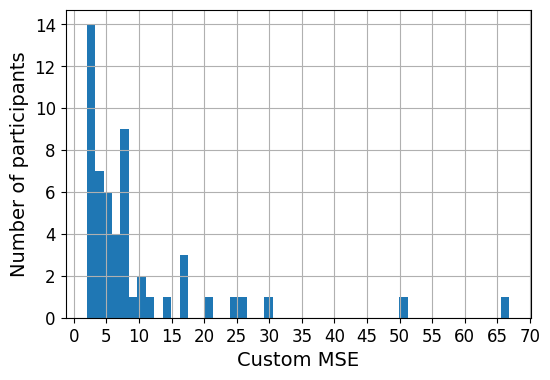

In [23]:
 folder_name = '/content/drive/MyDrive/sleep onset datasets/FIXED_regression_LSTM_perfectly_clean_onset/test_best_models_from_pretrained'

 hidden_size = 256
 batch_size = 32
 window_size_minutes = 3
 imputation_method = 'LOCF'

results_dir = os.path.join(folder_name, f'hidden_{hidden_size}_batch_{batch_size}_window_{window_size_minutes}_imputation_{imputation_method}/random_participants')
reg_results_LOCF = pd.read_csv(results_dir + '/regression_results_random_participants.csv')

# plot a histogram of 'custom_M
reg_results_LOCF['custom_MSE'].hist(bins=50)
# set xticks to have a step of 5
xmin, xmax = plt.xlim()
plt.xticks(range(0, int(xmax)+1, 5))

# Increase font sizes
plt.xlabel('Custom MSE', fontsize=14)
plt.ylabel('Number of participants', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# set figure size
plt.gcf().set_size_inches(6, 4)

plt.show()


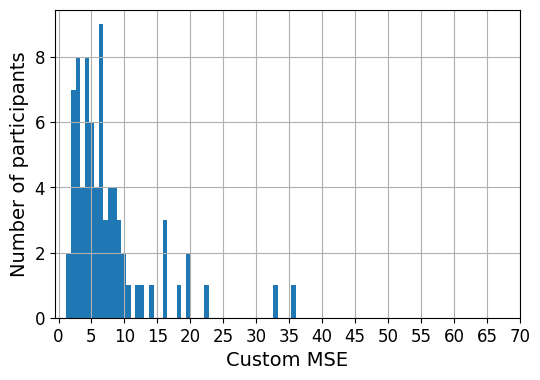

In [24]:
 folder_name = '/content/drive/MyDrive/sleep onset datasets/FIXED_regression_LSTM_clean_onset/test_best_models_from_pretrained'

 hidden_size = 64
 batch_size = 64
 window_size_minutes = 3
 imputation_method = 'LOCF'

results_dir = os.path.join(folder_name, f'hidden_{hidden_size}_batch_{batch_size}_window_{window_size_minutes}_imputation_{imputation_method}/random_participants')
reg_results_LOCF = pd.read_csv(results_dir + '/regression_results_random_participants.csv')

# plot a histogram of 'custom_M
reg_results_LOCF['custom_MSE'].hist(bins=50)
# set xticks to have a step of 5
#xmin, xmax = plt.xlim()
plt.xticks(range(0, int(xmax)+1, 5))

# Increase font sizes
plt.xlabel('Custom MSE', fontsize=14)
plt.ylabel('Number of participants', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# set figure size
plt.gcf().set_size_inches(6, 4)

plt.show()


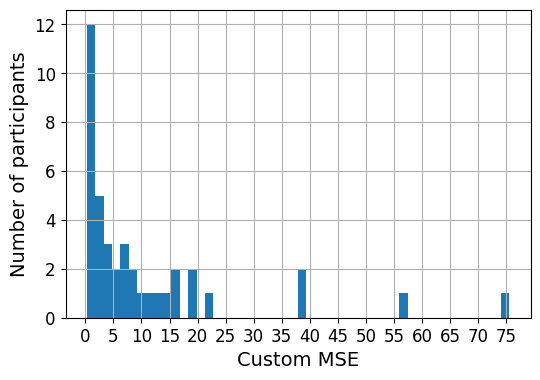

In [20]:
 folder_name = '/content/drive/MyDrive/sleep onset datasets/FIXED_regression_LSTM_perfectly_clean_onset/test_best_models_from_pretrained'

 hidden_size = 256
 batch_size = 32
 window_size_minutes = 5
 imputation_method = 'None'

results_dir = os.path.join(folder_name, f'hidden_{hidden_size}_batch_{batch_size}_window_{window_size_minutes}_imputation_{imputation_method}/random_participants')
reg_results_None= pd.read_csv(results_dir + '/regression_results_random_participants.csv')

# plot a histogram of 'custom_M
reg_results_None['custom_MSE'].hist(bins=50)
# set xticks to have a step of 5
xmin, xmax = plt.xlim()
plt.xticks(range(0, int(xmax)+1, 5))

# Increase font sizes
plt.xlabel('Custom MSE', fontsize=14)
plt.ylabel('Number of participants', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# set figure size
plt.gcf().set_size_inches(6, 4)

plt.show()
